In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

In [3]:
def fourier_analyze(x):
    
    '''
    return the real and imaginary parts of the DFT of x
    
    A0   = DFT[0] (DC component)
    A[j] = (1/2)*(DFT[j] + DFT[-j])
    B[j] = (i/2)*(DFT[j] - DFT[-j])
    
    or , equivalently
    
    DFT[j] = A[j] - i B[j]
    
    '''
    
    N = len(x)
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2-1)
    else:
        numFreqs = int((N-1)/2)        
        
    # calculate fourier cosine and sine components for positive freqs
    A = np.zeros(numFreqs)
    B = np.zeros(numFreqs)

    for j in range(numFreqs):
        for k in range(N):
            A[j] = A[j] + x[k]*np.cos(2*np.pi*(j+1)*k/N)
            B[j] = B[j] + x[k]*np.sin(2*np.pi*(j+1)*k/N)
    
    # constant term
    A0 = np.sum(x)
    
    return A0, A, B

In [4]:
def simulate_random_fourier_sum(N, seed):
    
    '''
    simulated time series x using random DFT components
    
    
    x[k] = a0 + sum_j(positive freq) ( a[j] cos(2pi jk/N) + b[j] sin(2pi jk/N) )
    
    
    '''
    
    # set seed for random number generator
    np.random.seed(seed)
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2-1)
    else:
        numFreqs = int((N-1)/2)   
    
    # random DFT components 
    A0 = np.random.randn()
    A = np.random.randn(numFreqs)
    B = np.random.randn(numFreqs)
    
    # relate DFT components to 
    a0 = A0/N
    a = (2/N)*A
    b = (2/N)*B
    
    # simulate time domain signal
    x = np.zeros(N)
    for k in range(N):
        for j in range(numFreqs):
            x[k] = x[k] + a[j]*np.cos(2*np.pi*(j+1)*k/N) + b[j]*np.sin(2*np.pi*(j+1)*k/N)
            
    x = x + a0
    
    return x, A0, A, B

In [5]:
def powerLaw(A, alpha, fref, N, deltaT, t0, seed):
    
    '''
    simulate evenly-sampled time series data having dimensionless characteristic strain 
    
    hc(f) = A (f/fref)^alpha
    
    and 1-sided power spectra (units time^2/Hz for timing residual measurements)
    
    P(f) =  1 /(12 pi^2 f^2) hc^2(f)/f
    
    '''
    
    # set seed for random number generator
    np.random.seed(seed)
    
    # check fref
    if fref > 1/(2*deltaT):
        print('error in powerLaw(): fref greater than fNyquist')
        return
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2 - 1)
    else:
        numFreqs = int((N-1)/2)

    T = N*deltaT   
    deltaF = 1/T
    f = deltaF*np.arange(1,numFreqs+1,1)  # arange doesn't include last value
    
    # generate ASD in frequency domain (random phases)
    # normalisation factor (discrete freqs > 0)
    Rf = 1/(12*np.pi**2 * f**2)
    hc = A * (f/fref)**alpha
    PSD = Rf * hc**2 / f
    norm = np.sqrt(N/(2*deltaT)) * np.sqrt(PSD)
    
    x = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    y = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    scale = norm[0]*np.sqrt(1./2.)
    r = np.sqrt(x**2 + y**2)
    z = x + 1j*y
    
    # alternative approach
    '''
    phi = np.random.uniform(0,2*np.pi,numFreqs)
    r = np.random.rayleigh(scale,numFreqs) 
    #r = scale*np.ones(numFreqs) 
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    z = x + 1j*y
    plt.plot(r)
    plt.plot(np.mean(r)*np.ones(len(r)))
    print(np.mean(r), scale*np.sqrt(np.pi/2) )
    '''
    
    if np.mod(N,2)==0:
        # note that most negative frequency is -f_Nyquist when N=even 
        temp1 = np.append(np.array([0]), z)
        temp2 = np.append(np.array([0]), np.flipud(np.conj(z)))
        dtilde = np.append(temp1, temp2)
    else:
        # no Nyquist frequency when N=odd
        temp1 = np.append(np.array([0]), z)
        dtilde = np.append(temp1, np.flipud(np.conj(z))) 
    
    # fourier transform back to time domain
    d = np.fft.ifft(dtilde)
    d = np.real(d) # imag part = 0 to round off
    
    t = t0 + deltaT*np.arange(0, N, 1)
    
    return d, t, dtilde

32 32 17 15 15
0j (-2.220446049250313e-16+0j) 8.881784197001252e-16
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89815432+3.07760552j
 -1.56551086-3.85976455j  2.4220139 +1.42660611j -2.74460137+2.33186565j
  4.73344018+4.40525466j  2.1958273 -2.48345542j -1.58487626-1.7079808j ]
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89815432+3.07760552j
 -1.56551086-3.85976455j  2.4220139 +1.42660611j -2.74460137+2.33186565j
  4.73344018+4.40525466j  2.1958273 -2.48345542j -1.58487626-1.7079808j ]
[-2.83915751+5.49487481j -0.06876473-0.87890729j  1.27764548+0.63897686j
 -9.06132428+3.89240955j -5.50981466-0.03399021j  7.79992293+3.96374178j
 -2.25524029-5.79555165j -3.37495035-5.80518674j  0.89

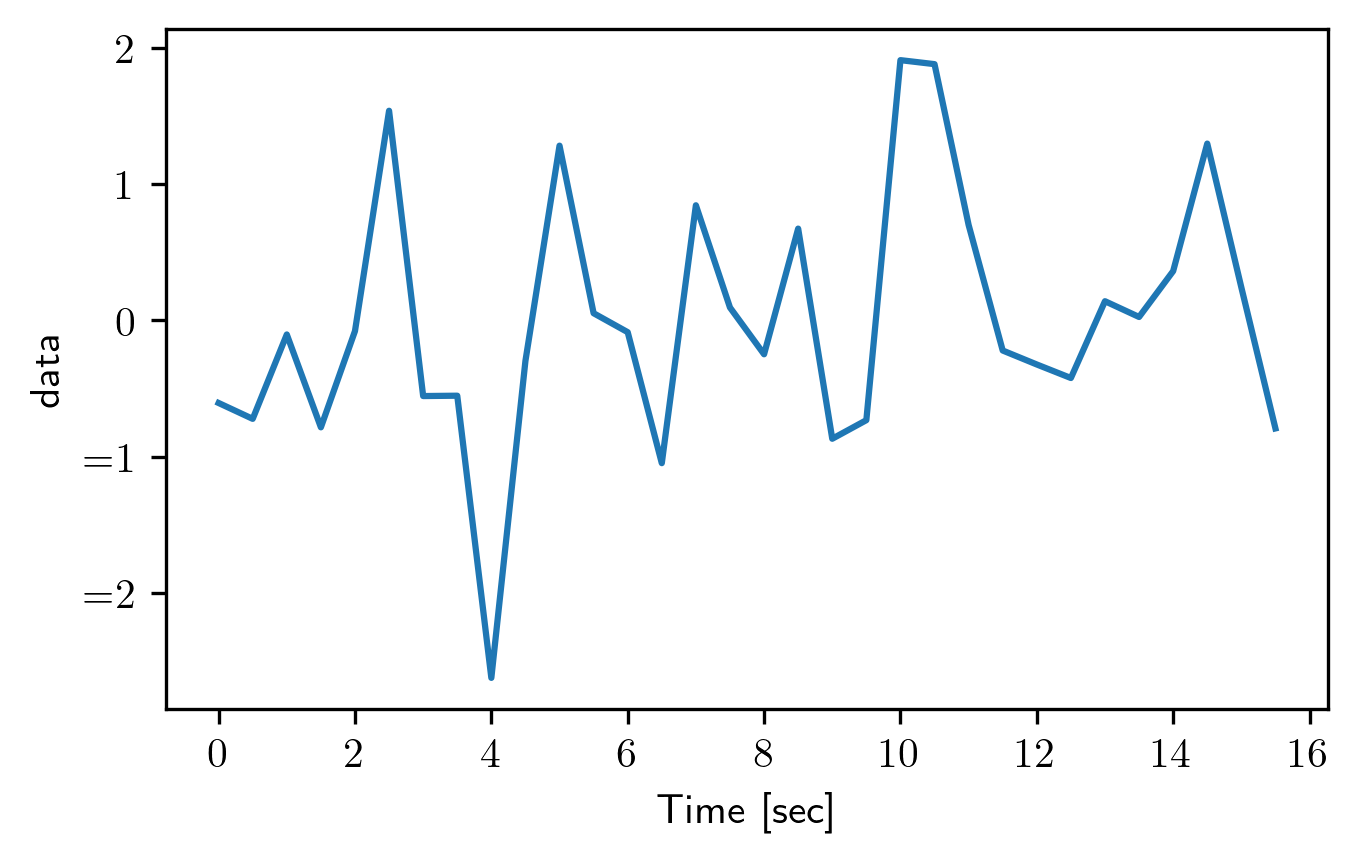

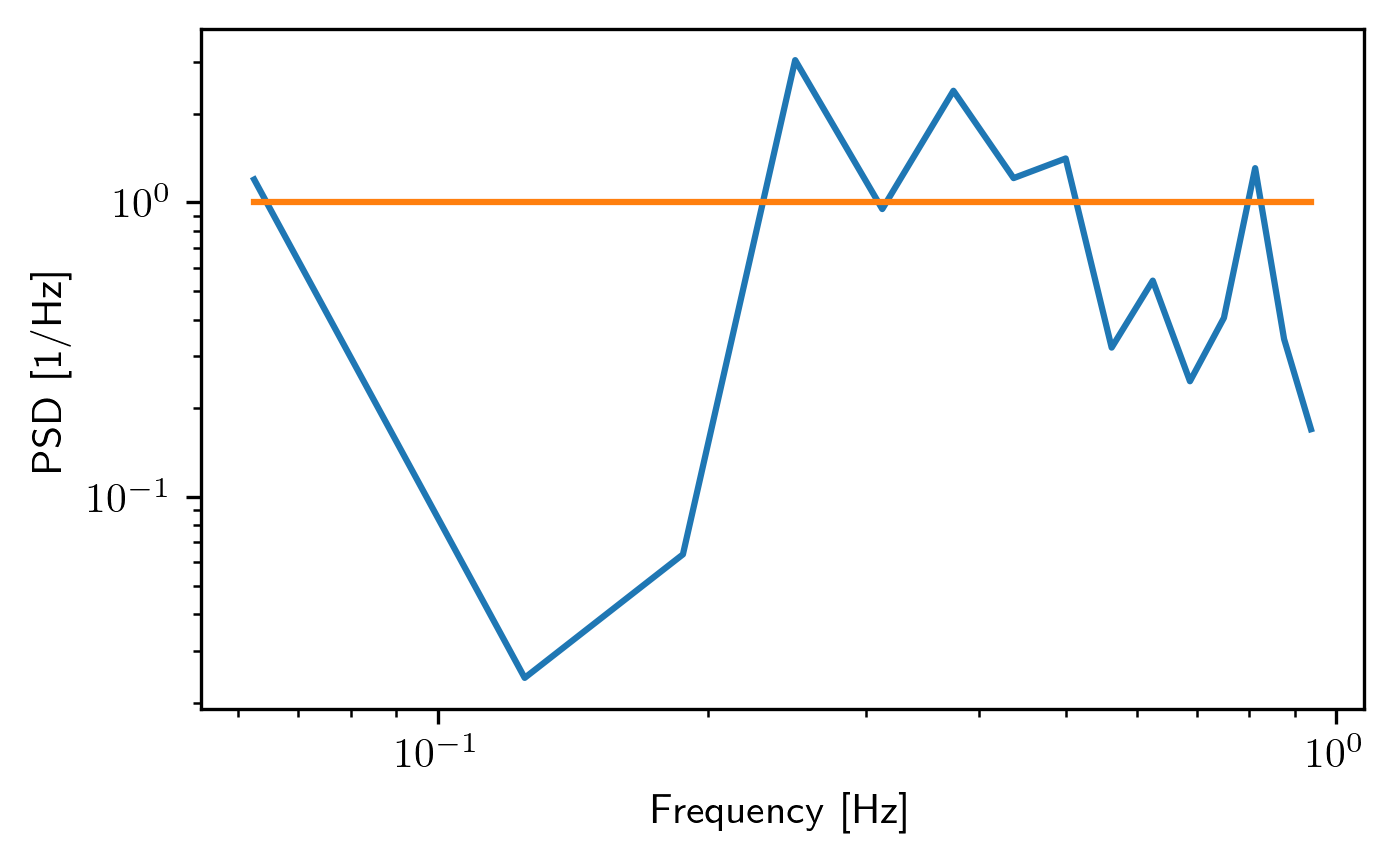

In [9]:
# simulate white noise with power spectra P = 2 sigma^2 deltaT

# parameters for white noise
sigma = 1
deltaT = 0.5
t0=0
T = 16
N = int(T/deltaT)

# convert to A, alpha
alpha = 3/2
fref = 1 # can be anything
A = np.sqrt(24*np.pi**2 * sigma**2 * deltaT * fref**3)

# simulate data
d, t, dtilde_sim = powerLaw(A, alpha, fref, N, deltaT, t0, 5678)

# time-series
plt.figure()
plt.plot(t,d)
plt.xlabel('Time [sec]')
plt.ylabel('data')
plt.savefig('simulated_data_white_time.pdf', bbox_inches='tight', dpi=400)

# power spectrum
deltaF = 1/T
numFreqs = int(N/2)
freqs = deltaF*np.arange(1,numFreqs,1)

# plot estimated PSD and reference PSD
dtilde_fft = np.fft.rfft(d) 
dtilde = dtilde_fft*deltaT
dtilde = dtilde[1:-1]
psd_est = (2/T)*np.abs(dtilde)**2
psd_ref = 2*sigma**2 * deltaT * np.ones(len(dtilde))

plt.figure()
plt.loglog(freqs, psd_est, label='simulated data')
plt.loglog(freqs, psd_ref, label='reference')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
#plt.legend()
plt.savefig('simulated_data_white_freq.pdf', bbox_inches='tight', dpi=400)

# compare fourier coefficients obtained in different ways
A0, A, B = fourier_analyze(d)
print(len(d), len(dtilde_sim), len(dtilde_fft), len(dtilde), len(A))

print(dtilde_sim[0], dtilde_fft[0], A0)
print(dtilde_sim[1:numFreqs])
print(dtilde_fft[1:-1])
print(A-1j*B)
print(np.real(dtilde_fft[1:-1])/A)
print(-np.imag(dtilde_fft[1:-1])/B)

-0.7097893778645774 [-0.01719118  0.31941137 -2.26533107 -1.37745366  1.94998073 -0.56381007
 -0.84373759] [ 0.22453858 -0.39137772  0.60550347 -0.68615034  1.18336005  0.54895683
 -0.39621907]
-0.7097893778645772 [-0.01719118  0.31941137 -2.26533107 -1.37745366  1.94998073 -0.56381007
 -0.84373759] [ 0.22453858 -0.39137772  0.60550347 -0.68615034  1.18336005  0.54895683
 -0.39621907]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]


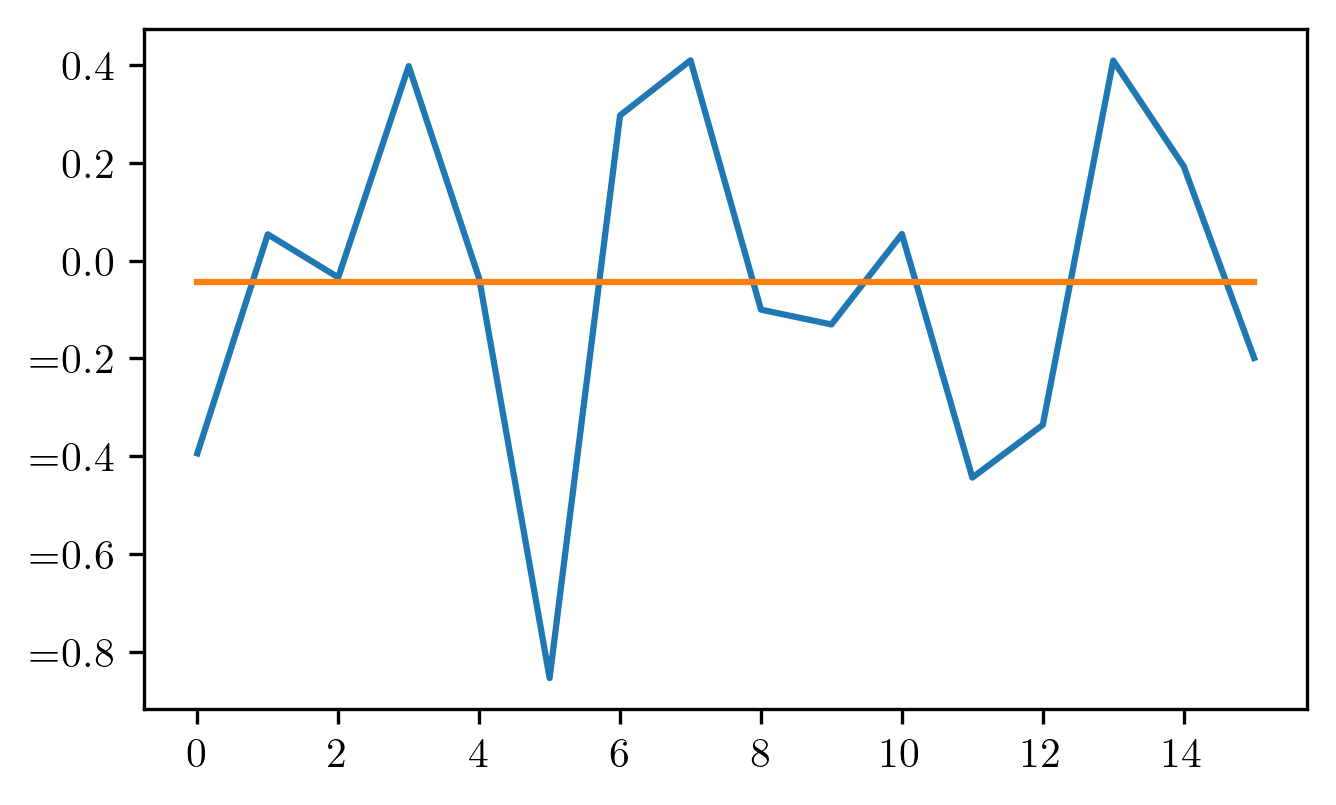

In [10]:
# test fourier_simulate / analyze routines

# simulate
N = 16
x, A0, A, B = simulate_random_fourier_sum(N, 5678)
print(A0, A, B)

# plot signal
plt.plot(x)
plt.plot(np.mean(x)*np.ones(N))

# analyze
A0, A, B = fourier_analyze(x)
print(A0, A, B)

xdft = np.fft.rfft(x)
print(np.real(xdft[1:-1])/A)
print(-np.imag(xdft[1:-1])/B)

In [225]:
# "continuous" functions on the circle
N = 360
thetas = np.linspace(-np.pi, np.pi, N)

# amplitude9
C = np.ones(N)

# random phase
random.seed(1234)
phis = 2*np.pi*random.rand(N)

# oscillating phase
#N_phi = 18 # number of phase oscillations around the circle
#dTheta_phi = 2*np.pi/N_phi
#phi = 2*np.pi*np.cos(2*np.pi*thetas/dTheta_phi)

# real and imag parts
A = C*np.cos(phis)
B = C*np.sin(phis)

print(min(phis), max(phis), np.std(phis))
print(min(phis**2))

0.013756599578923862 6.280983639904923 1.8359071871358297
0.00018924403197484818


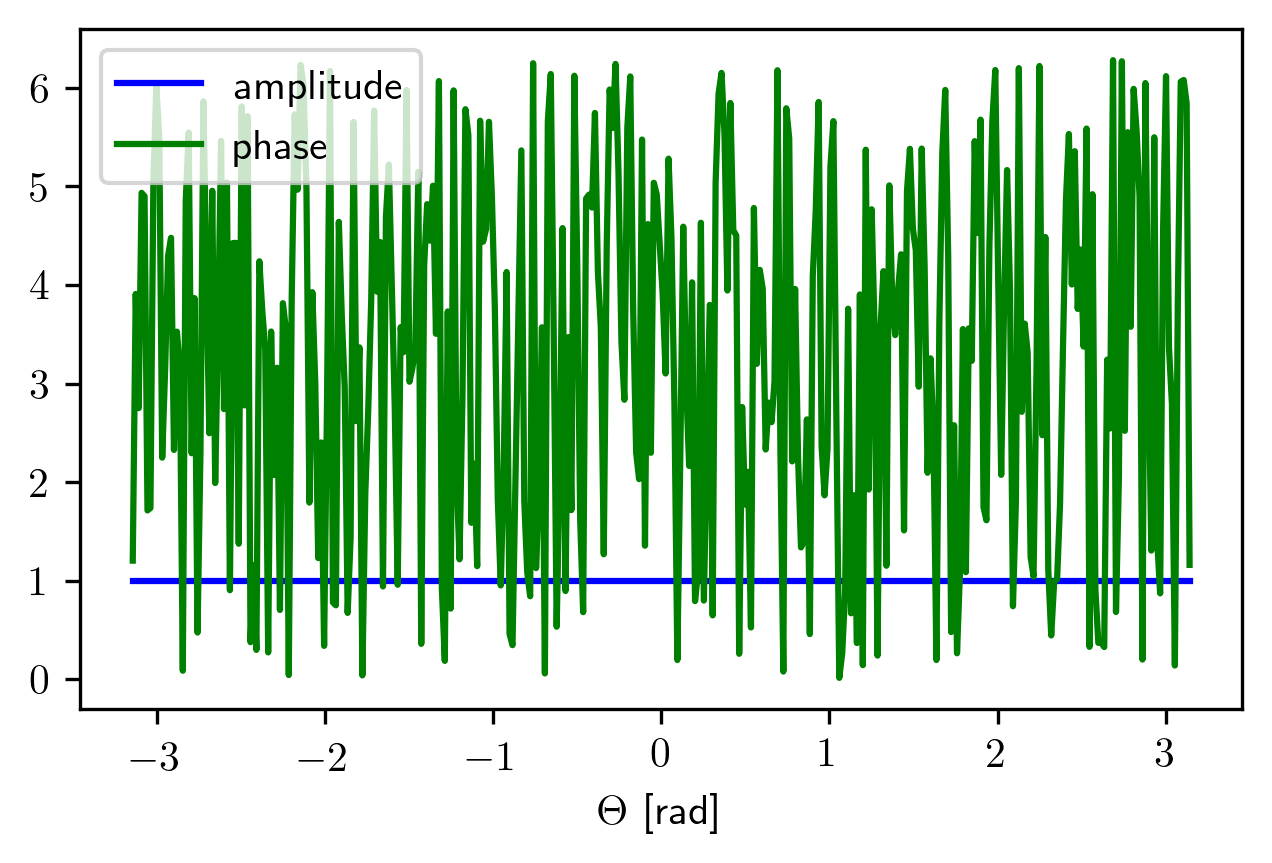

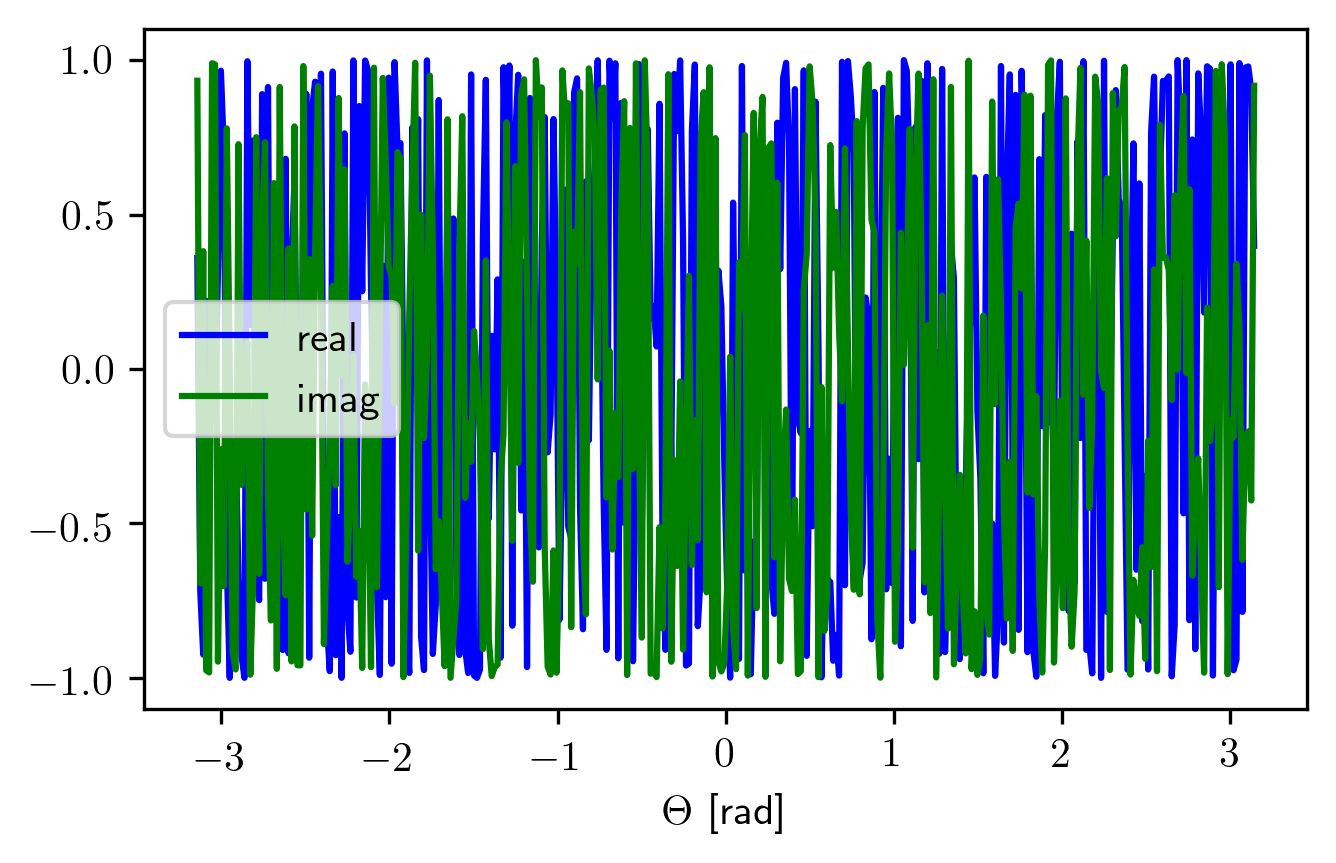

In [40]:
# plot data
plt.figure()
plt.plot(thetas, C, color='blue', label='amplitude')
plt.plot(thetas, phis, color='green', label='phase')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('amplitude_phase.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas, A, color='blue', label='real')
plt.plot(thetas, B, color='green', label='imag')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('real_imag.pdf', bbox_inches='tight', dpi=400)

In [42]:
# response function

def apply_response(x, theta0, dTheta_resp, thetas):
    '''
    calculate response which averages together theta values around theta0
    '''
    
    theta_min = theta0 - 0.5*dTheta_resp
    theta_max = theta0 + 0.5*dTheta_resp
    
    ndx = np.where((theta_min <= thetas) & (thetas <= theta_max))
    y = np.mean(x[ndx[0]])
    
    return y

In [57]:
# apply response around circle to get measured data
N_d = N//4
dTheta_d = 2*np.pi/N_d

A_d = np.zeros(N_d)
B_d = np.zeros(N_d)
C_d = np.zeros(N_d)
thetas_d = np.zeros(N_d)
for ii in range(N_d):
    
    theta_i = -np.pi + ii*dTheta_d
    thetas_d[ii] = theta_i
    A_d[ii] = apply_response(A, theta_i, dTheta_d, thetas)
    B_d[ii] = apply_response(B, theta_i, dTheta_d, thetas)
    C_d[ii] = apply_response(C, theta_i, dTheta_d, thetas)



0.3392017288223077 0.3717956140673337


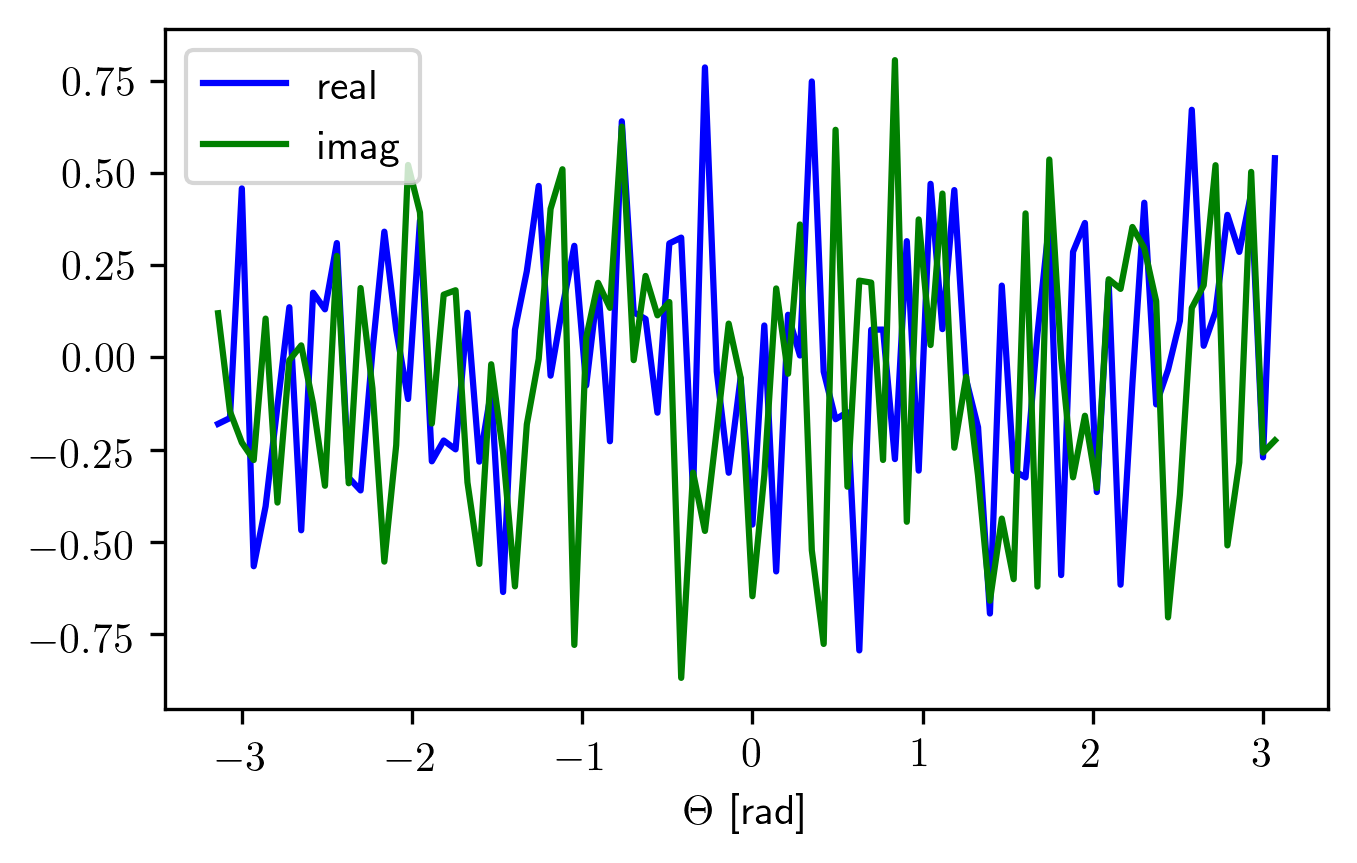

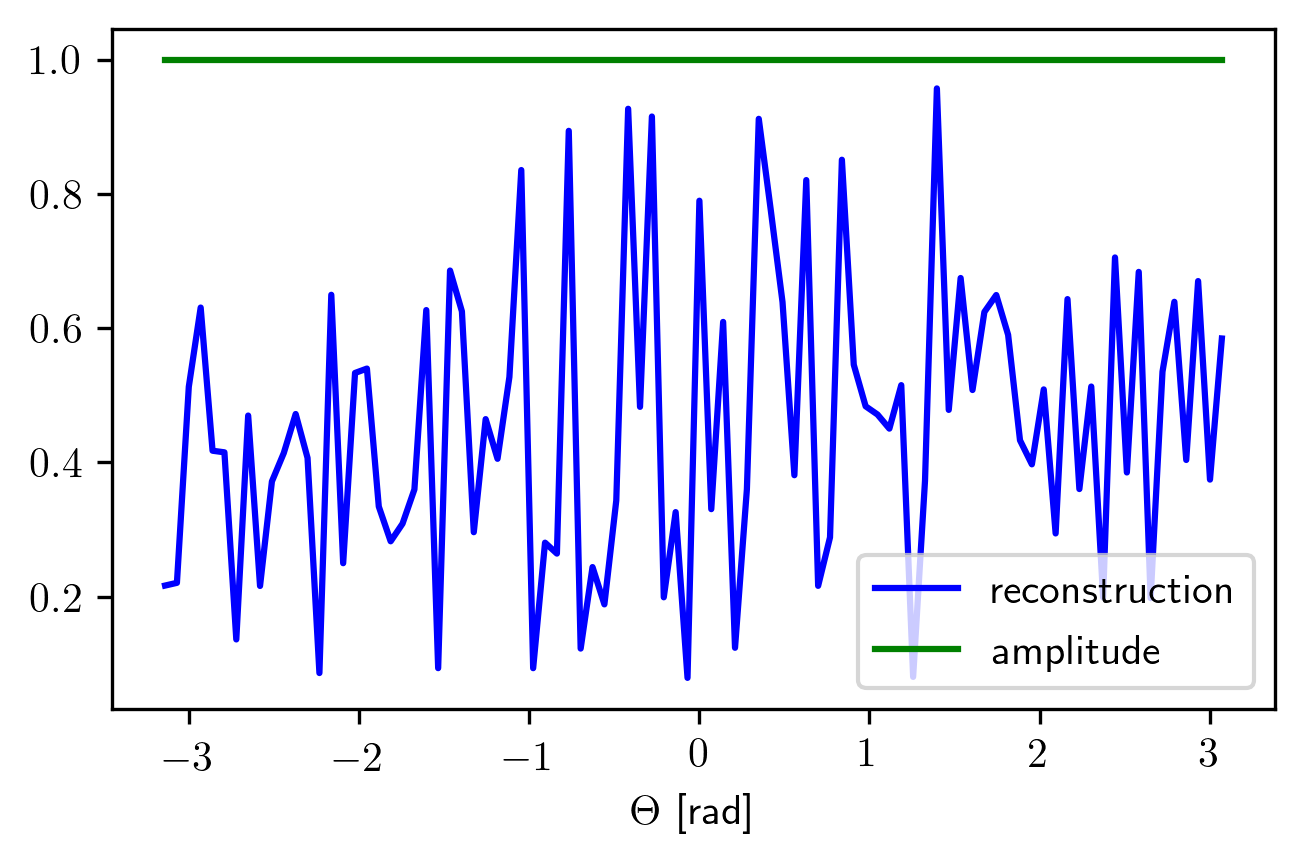

In [58]:
# plot measureed data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas_d, A_d, color='blue', label='real')
plt.plot(thetas_d, B_d, color='green', label='imag')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('real_imag_reconstruction.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas_d, np.sqrt(A_d**2 + B_d**2), color='b', label='reconstruction')
plt.plot(thetas_d, C_d, color='g', label='amplitude')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('amplitude_reconstruction.pdf', bbox_inches='tight', dpi=400)

print(np.std(A_d), np.std(B_d)) # 1/sqrt(2* N/N_d)

## trying to tie it all together with a phase correlation scale

0.0014278533217819422 6.282957376958533 1.8438516975271961
2.0387651085237267e-06


(array([213., 194., 155., 155., 186., 196., 162., 183., 183., 173.]),
 array([1.42785332e-03, 6.29580806e-01, 1.25773376e+00, 1.88588671e+00,
        2.51403966e+00, 3.14219262e+00, 3.77034557e+00, 4.39849852e+00,
        5.02665147e+00, 5.65480442e+00, 6.28295738e+00]),
 <a list of 10 Patch objects>)

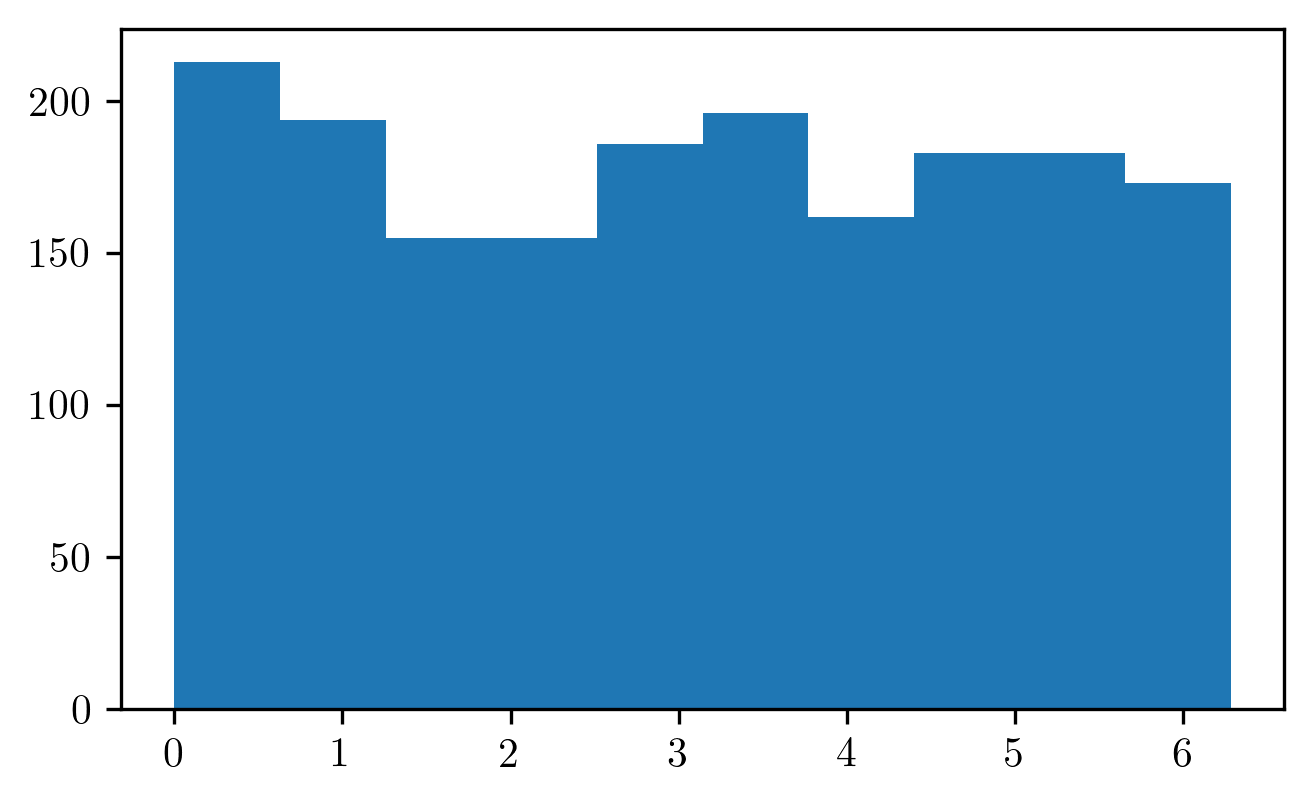

In [123]:
# "continuous" functions on the circle
N = 180      # detector sampling on circle 

sampling_resolution = 2*np.pi/N
delta_phi = sampling_resolution/10

input_resolution = int(2*np.pi/delta_phi)

N_in = input_resolution

# amplitude
C = np.sqrt(2) * np.ones(N_in)
thetas = np.linspace(-np.pi, np.pi, N_in)

# random phase
random.seed(1234)
phis = 2*np.pi*np.random.rand(N_in)  #2*np.pi*random.rand(N)

# oscillating phase
#N_phi = 18 # number of phase oscillations around the circle
#dTheta_phi = 2*np.pi/N_phi
#phi = 2*np.pi*np.cos(2*np.pi*thetas/dTheta_phi)

# real and imag parts
A = C*np.cos(phis)
B = C*np.sin(phis)

print(min(phis), max(phis), np.std(phis))
print(min(phis**2))

plt.hist(phis)

1.0169811159825415 0.9821811032186909


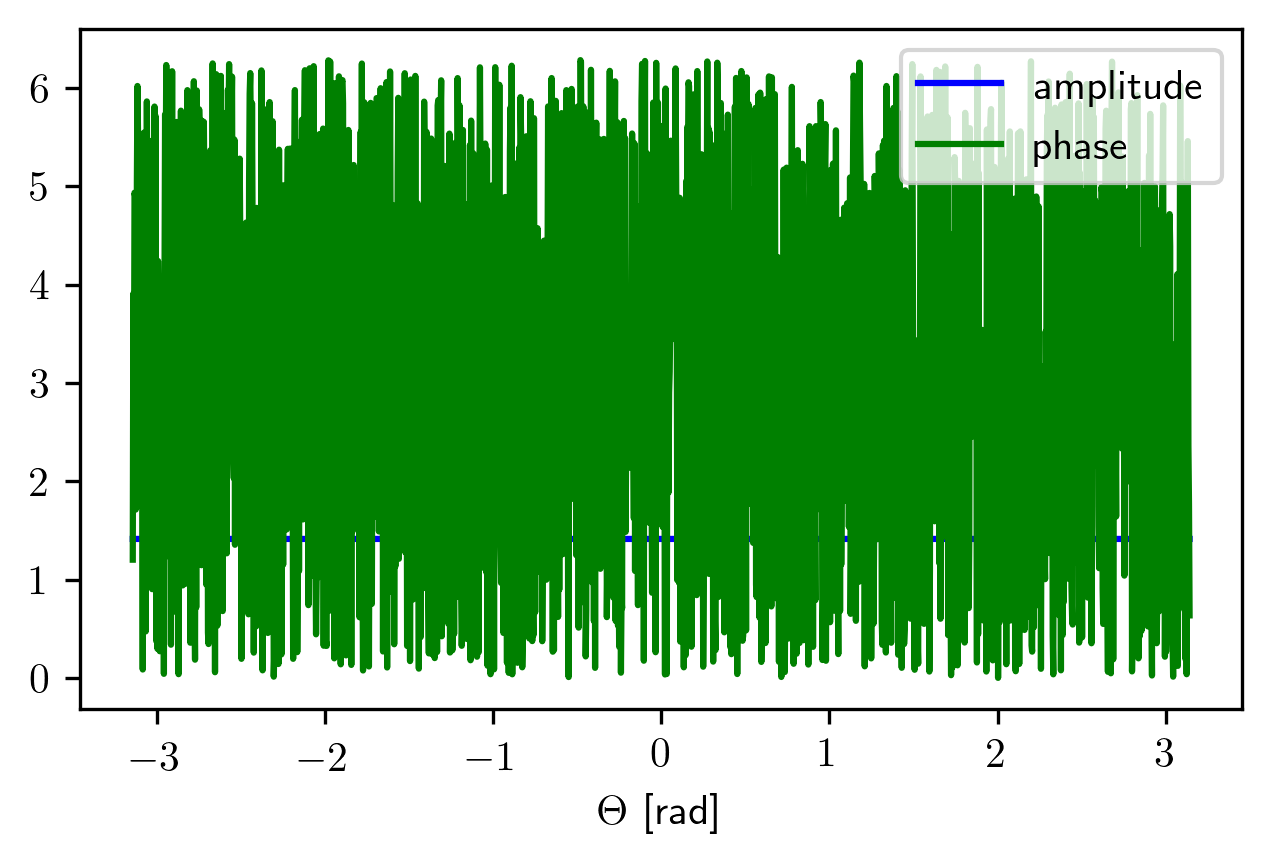

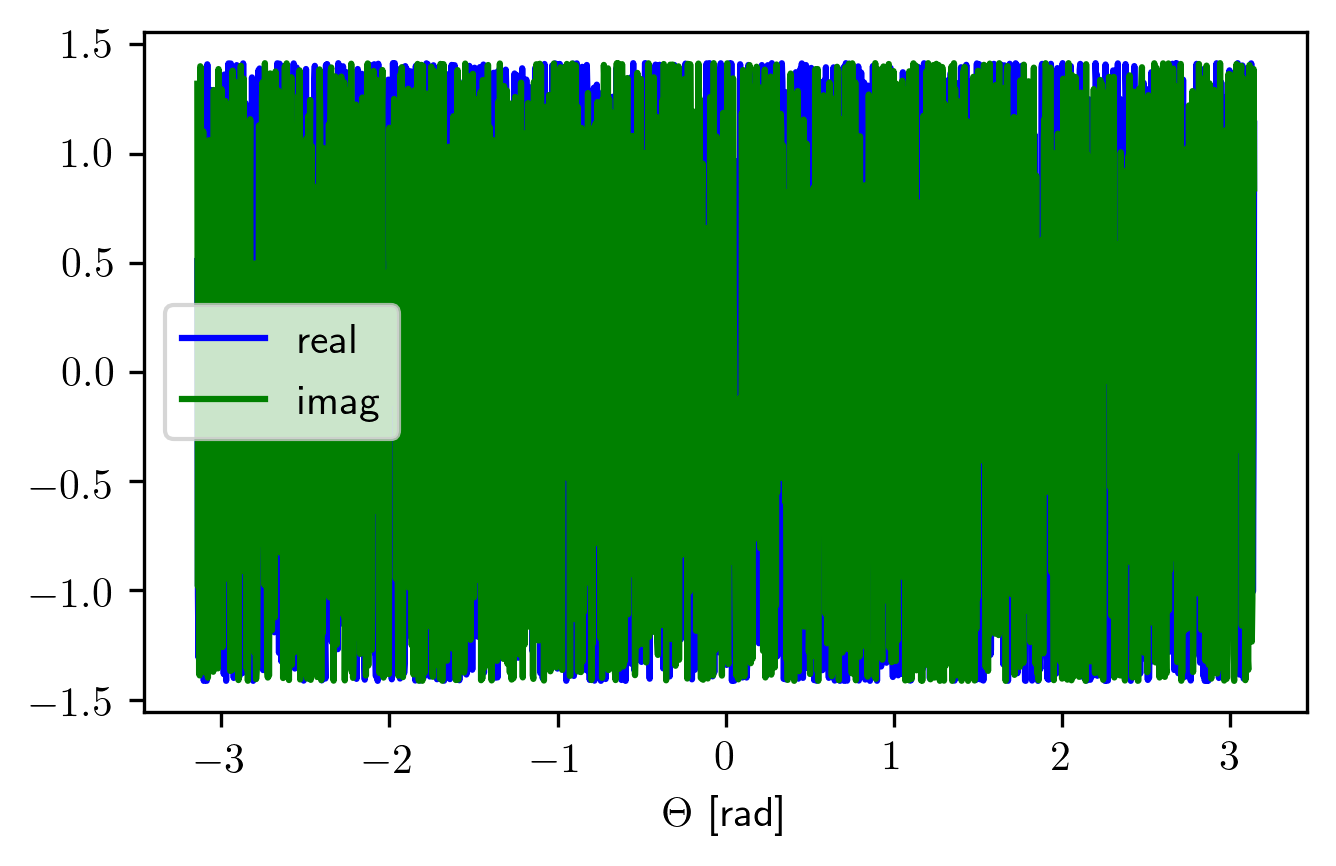

In [124]:
# plot data
plt.figure()
plt.plot(thetas, C, color='blue', label='amplitude')
plt.plot(thetas, phis, color='green', label='phase')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('amplitude_phase.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas, A, color='blue', label='real')
plt.plot(thetas, B, color='green', label='imag')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('real_imag.pdf', bbox_inches='tight', dpi=400)

print(np.std(A), np.std(B))

In [125]:
# apply response around circle to get measured data
N_d = N
dTheta_d = 2*np.pi/N_d

A_d = np.zeros(N_d)
B_d = np.zeros(N_d)
C_d = np.zeros(N_d)
thetas_d = np.zeros(N_d)
for ii in range(N_d):
    
    theta_i = -np.pi + ii*dTheta_d
    thetas_d[ii] = theta_i
    A_d[ii] = apply_response(A, theta_i, dTheta_d, thetas)
    B_d[ii] = apply_response(B, theta_i, dTheta_d, thetas)
    C_d[ii] = apply_response(C, theta_i, dTheta_d, thetas)

0.3059980384636981 0.2913595459664632


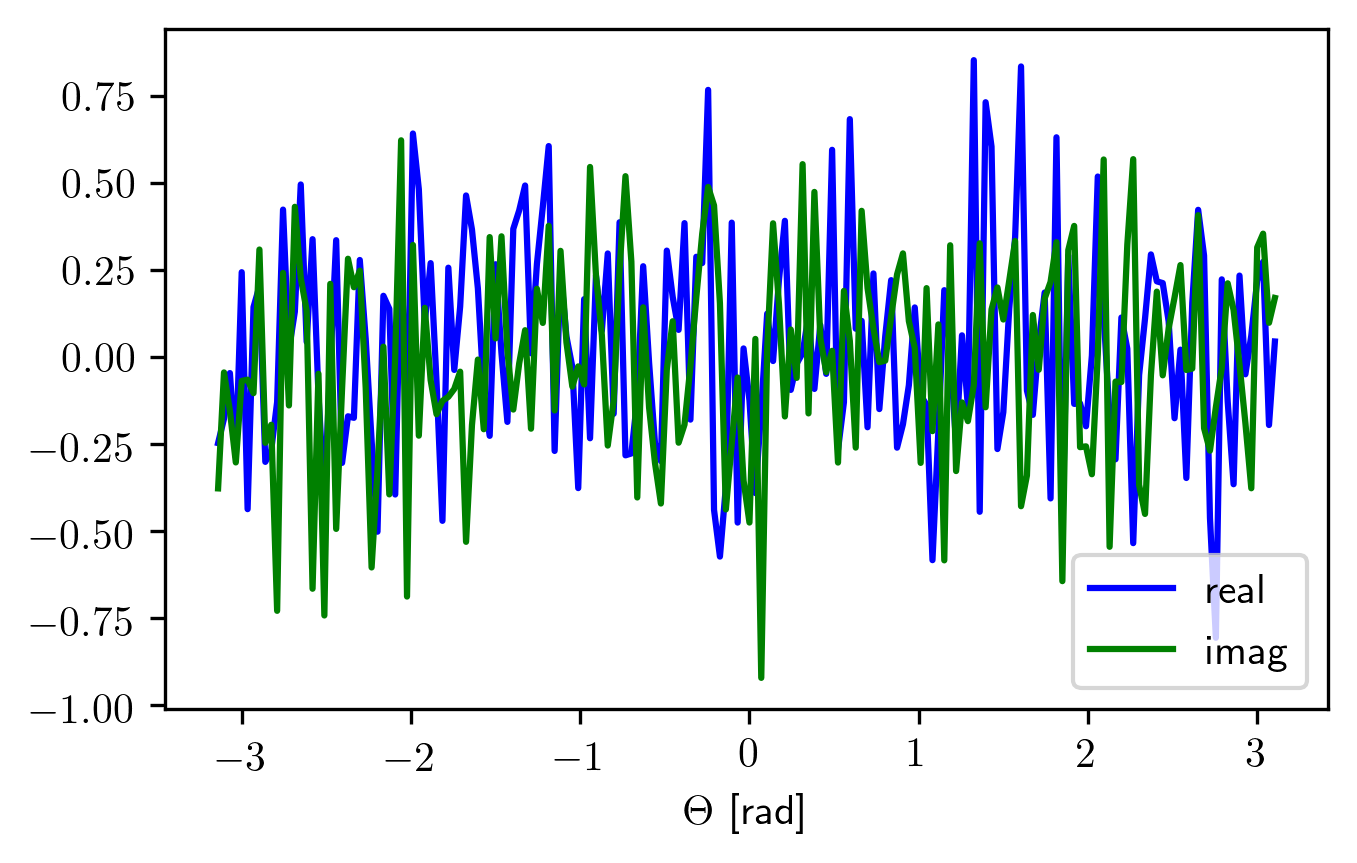

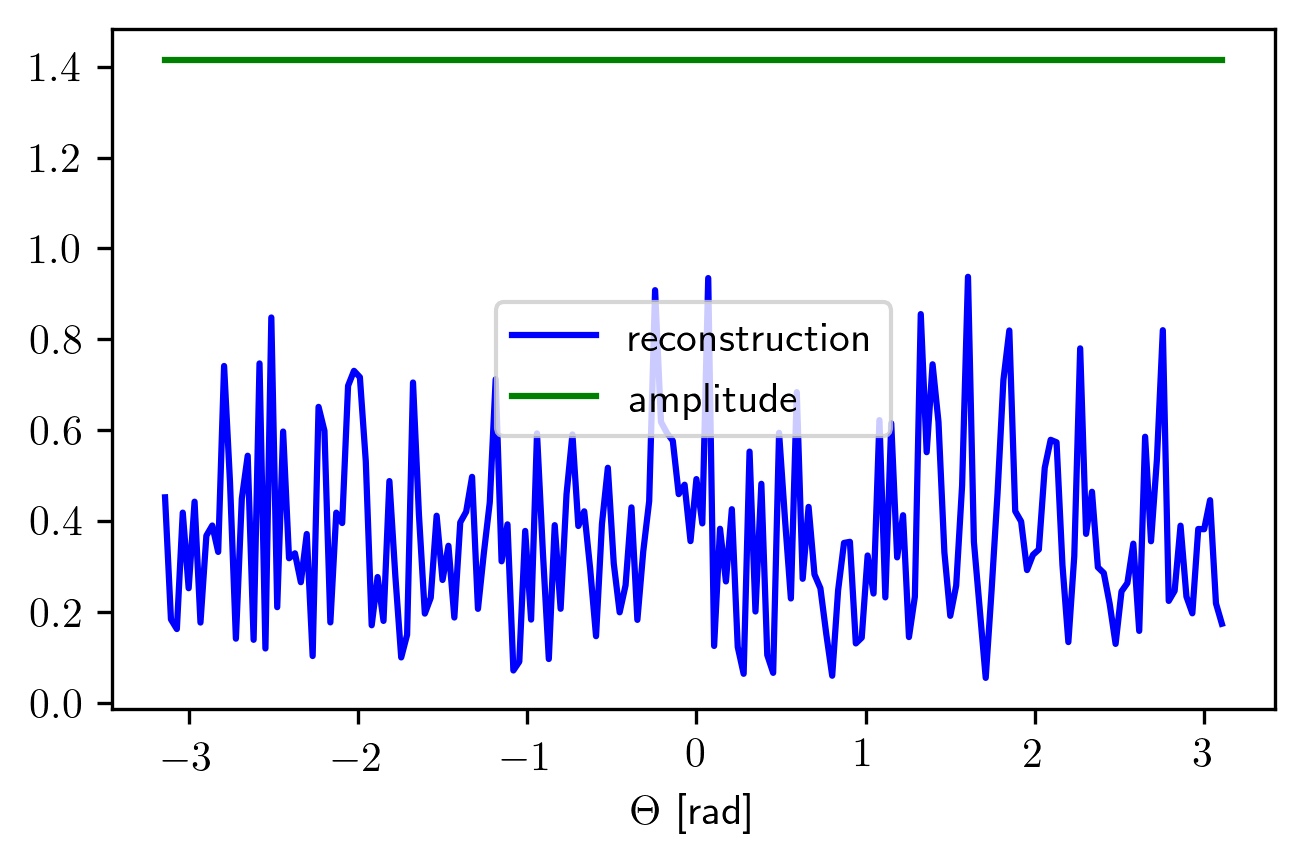

In [126]:
# plot measureed data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas_d, A_d, color='blue', label='real')
plt.plot(thetas_d, B_d, color='green', label='imag')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('real_imag_reconstruction.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(thetas_d, np.sqrt(A_d**2 + B_d**2), color='b', label='reconstruction')
plt.plot(thetas_d, C_d, color='g', label='amplitude')
plt.xlabel('$\Theta$ [rad]')
plt.legend()
plt.savefig('amplitude_reconstruction.pdf', bbox_inches='tight', dpi=400)

print(np.std(A_d), np.std(B_d)) # 1/sqrt(2* N/N_d)

/Users/pai/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pai/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['-', '--', '-.', ':', 'None', ' ', '']
nan nan
0.4317824685180273 0.43822876396452387
0.3059980384636981 0.2913595459664632
0.09345109072700128 0.09641760886853597
0.030350027805305137 0.02915508751450623
0.030350027805305137 0.02915508751450623


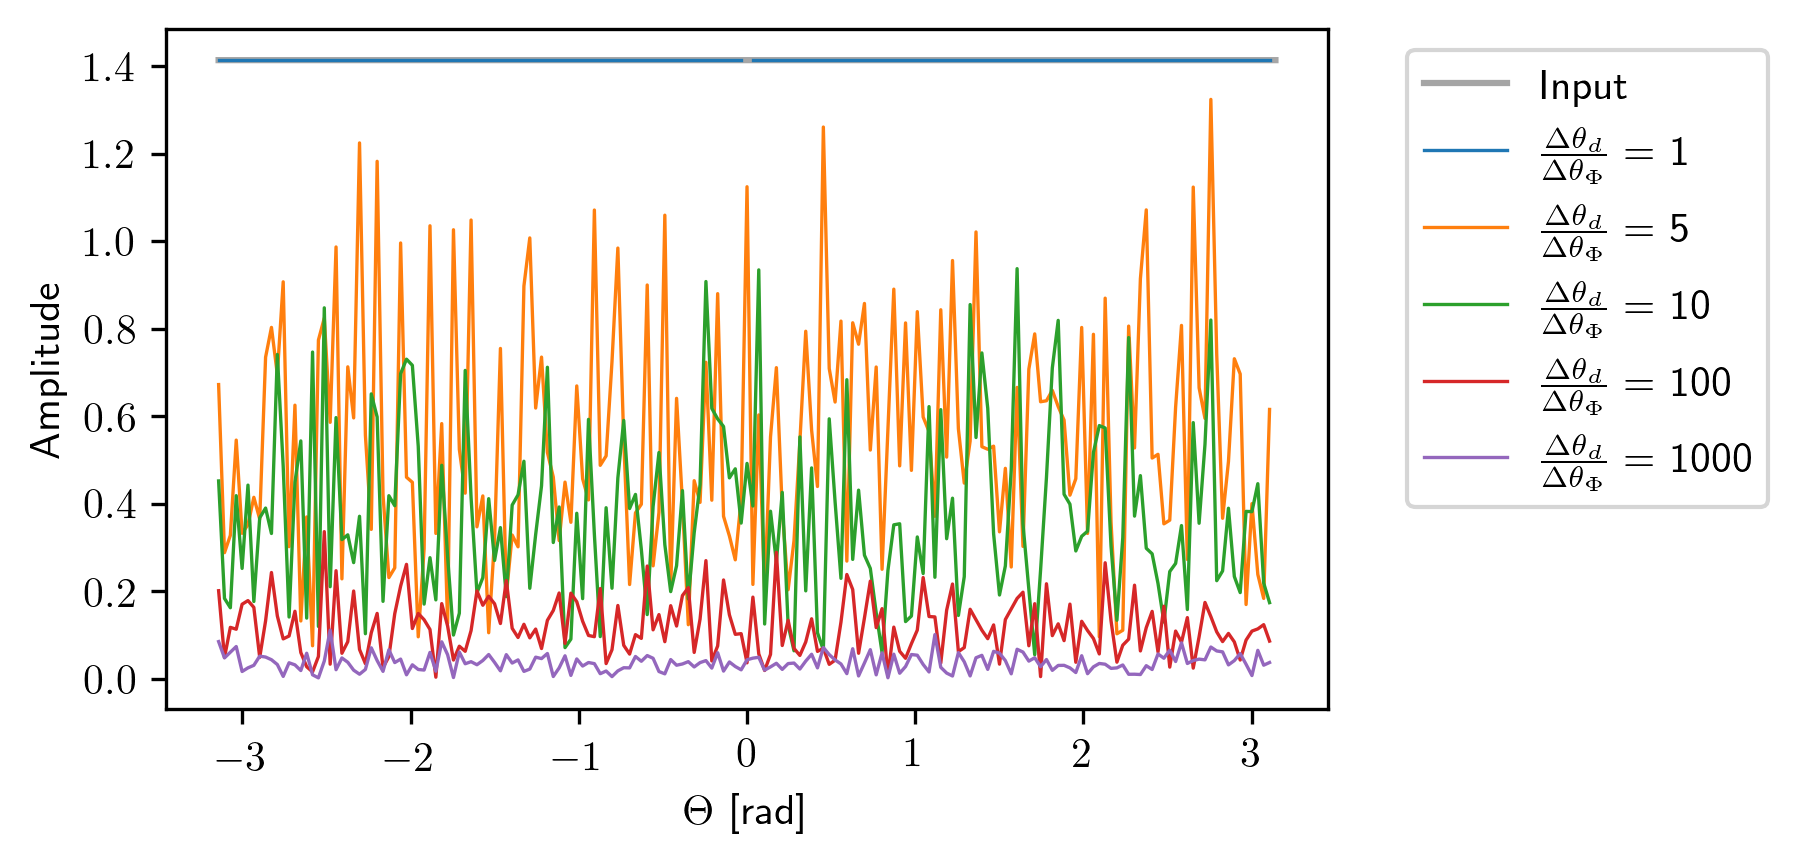

In [164]:
# "continuous" functions on the circle
N = 180      # detector sampling on circle 
sampling_resolution = 2*np.pi/N

facs = [1, 5, 10, 100, 1000]
A_outs = []
B_outs = []
theta_outs = []

for fac in facs:
    delta_phi = sampling_resolution/fac

    input_resolution = int(2*np.pi/delta_phi)
    N_in = input_resolution

    # amplitude
    C = np.sqrt(2) * np.ones(N_in)
    thetas = np.linspace(-np.pi, np.pi, N_in)
    
    # random phase
    random.seed(1234)
    phis = 2*np.pi*np.random.rand(N_in)  #2*np.pi*random.rand(N)
    
    A = C*np.cos(phis)
    B = C*np.sin(phis)
    
    # apply response around circle to get measured data
    N_d = N
    dTheta_d = 2*np.pi/N_d

    A_d = np.zeros(N_d)
    B_d = np.zeros(N_d)
    thetas_d = np.zeros(N_d)
    
    for ii in range(N_d):
        theta_i = -np.pi + ii*dTheta_d
        thetas_d[ii] = theta_i
        A_d[ii] = apply_response(A, theta_i, dTheta_d, thetas)
        B_d[ii] = apply_response(B, theta_i, dTheta_d, thetas)
        
    A_outs.append(A_d)
    B_outs.append(B_d)
    theta_outs.append(thetas_d)

plt.figure()
plt.rc('text', usetex=True)

import seaborn as sns
cp = sns.color_palette()
from matplotlib import lines
linesty = list(lines.lineStyles.keys())

print(linesty)

plt.plot(thetas, C, color='gray', label='Input', alpha = 0.7)
for idx in range(len(facs)):
    plt.plot(theta_outs[idx], np.sqrt(A_outs[idx]**2 + B_outs[idx]**2), label=r'$\frac{\Delta\theta_d}{\Delta\theta_\Phi} =$ '+str(facs[idx]), color = cp[idx], linestyle = '-', linewidth = 0.8)
    print(np.std(A_outs[idx]), np.std(B_outs[idx]))
plt.xlabel('$\Theta$ [rad]')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('amplitude_reconstruction.pdf', bbox_inches='tight', dpi=400)

print(np.std(A_d), np.std(B_d)) # 1/sqrt(2* N/N_d)

nan nan
0.4317824685180273 0.43822876396452387
0.3059980384636981 0.2913595459664632
0.09345109072700128 0.09641760886853597
0.030350027805305137 0.02915508751450623


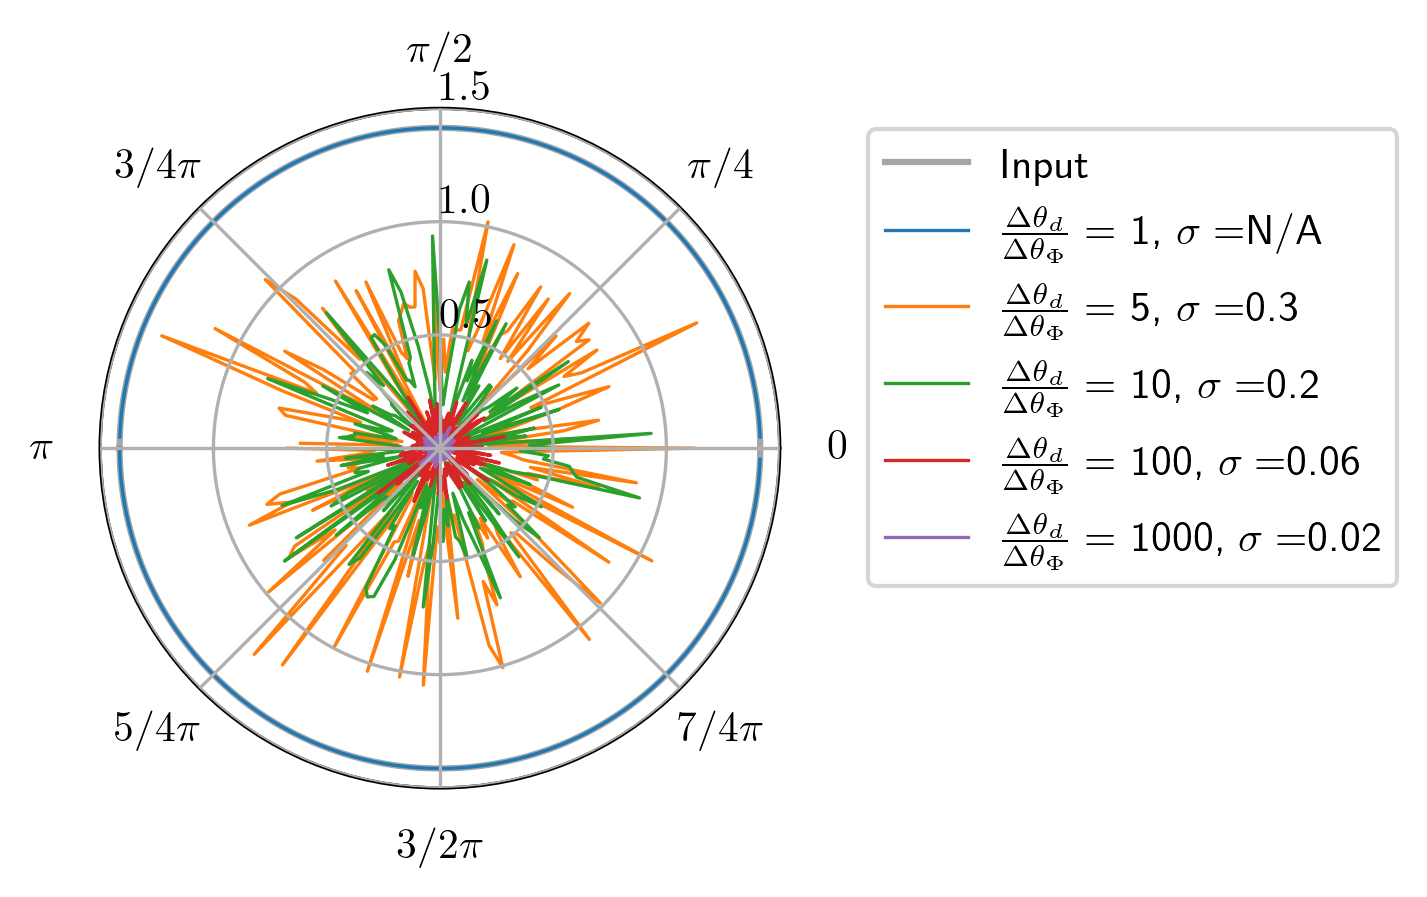

In [187]:
plt.rcParams["axes.axisbelow"] = False
sigmas = ['N/A', '0.3', '0.2', '0.06', '0.02']

ax = plt.subplot(111, polar=True)
ax.plot(thetas, C, color='gray', label='Input', alpha = 0.7)
for idx in range(len(facs)):
    ax.plot(theta_outs[idx], np.sqrt(A_outs[idx]**2 + B_outs[idx]**2), label=r'$\frac{\Delta\theta_d}{\Delta\theta_\Phi} =$ '+str(facs[idx]) + ', $\sigma = $' + sigmas[idx], color = cp[idx], linestyle = '-', linewidth = 0.8)
    print(np.std(A_outs[idx]), np.std(B_outs[idx]))
#plt.xlabel('$\Theta$ [rad]')
#plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4])
ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3/4\pi$', r'$\pi$', r'$5/4\pi$', r'$3/2\pi$', r'$7/4\pi$'])
ax.set_rlabel_position(90)
#ax.set_axisbelow(False)
ax.set_yticks([0.5, 1, 1.5])
plt.savefig('amplitude_reconstruction.pdf', bbox_inches='tight', dpi=400)
